In [1]:
import cv2 as cv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numba import jit
plt.rc('image', cmap='gray')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

### First Step (Initalitization)

* Loading an Image 
* Conveting it to BW
* Scale it to 600px width*

######  *asumption: Possible Pictures will have a roughly equal distance to the Grid

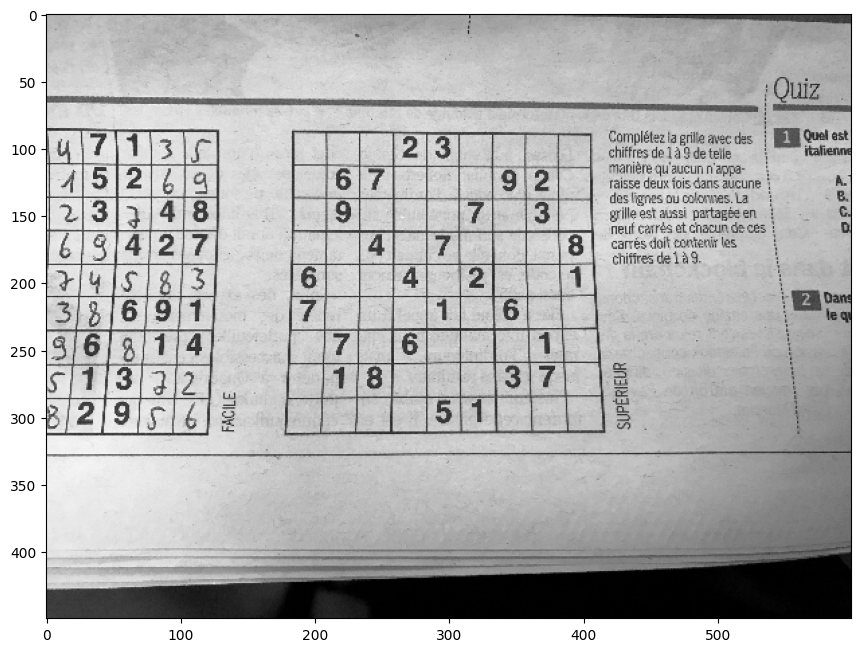

In [2]:
Org=cv.imread("Samples/2.jpg")
#Org=cv.imread("Samples/wichtounet/v2_test/image1088.jpg")
Org_Color=Org
Org=cv.resize(Org,(600,round(Org.shape[0]/Org.shape[1]*600)))
Org=cv.cvtColor(Org,cv.COLOR_RGB2GRAY)
Org=Org-np.min(Org)
plt.imshow(Org)

In [3]:

def variance_filter(I, n=7):
    #I=np.array(I,dtype=np.float)
    
    result=np.zeros(I.shape)
    
    
    mean=np.array(cv.GaussianBlur(I,(n,n),1,1),dtype=np.float)
    return variance_filter_jit(I,mean,n)
    
    
         
@jit(nopython=True)
def variance_filter_jit(I,mean,n):
    h,w=I.shape
    result=mean
    for y in range(h):
        for x in range(w):
            
            sum=0
            for i in range(-n//2,n//2+1):
                for j in range(-n//2,n//2+1):
                    
                    xi,yi=x+i,y+j   
                    sum+=(I[yi,xi]-result[y,x])*(I[yi,xi]-result[y,x])\
                          if xi>0 and yi>0 and yi<h and xi<w else 0
            
            result[y,x]=sum/(n**2-1)           
    return result   


### Second Step (Reducing Noise)
* Inverting the Original
* Using the variance to filter noisy regions from the image  (i.e. text)
* Thresholding the result


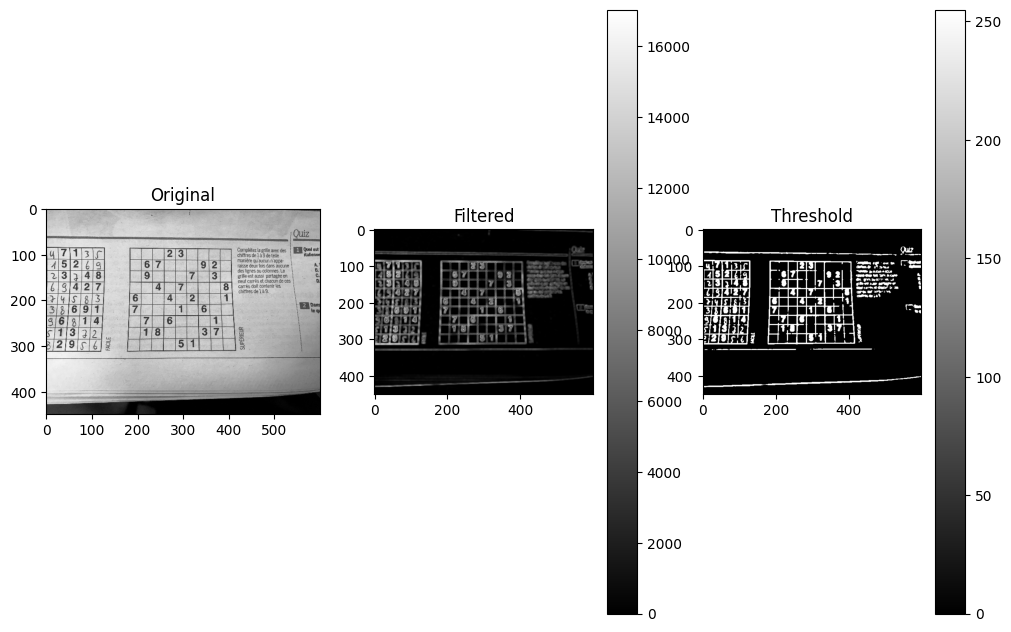

In [4]:

I=np.copy(Org)
I_var=variance_filter(I,5)
I=cv.bitwise_not(I)*I_var
I=I/np.max(I)*255
I=np.array(I,dtype=np.uint8)
I=cv.GaussianBlur(I,(3,3),5)
#I= cv.adaptiveThreshold(I,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY_INV,11,2)
I = cv.threshold(I,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)[1]
#I=cv.Canny(I,50,150,apertureSize = 3)
plt.subplot(131)
plt.imshow(Org)
plt.title("Original")
plt.subplot(132)
plt.imshow(I_var)
plt.title("Filtered")
plt.colorbar()
plt.subplot(133)
plt.imshow(I)
plt.title("Threshold")
plt.colorbar()
plt.show()

### Third Step (Aproximating the region of interest)
* Searching the biggest contour
* Using this contour for a perspective transform

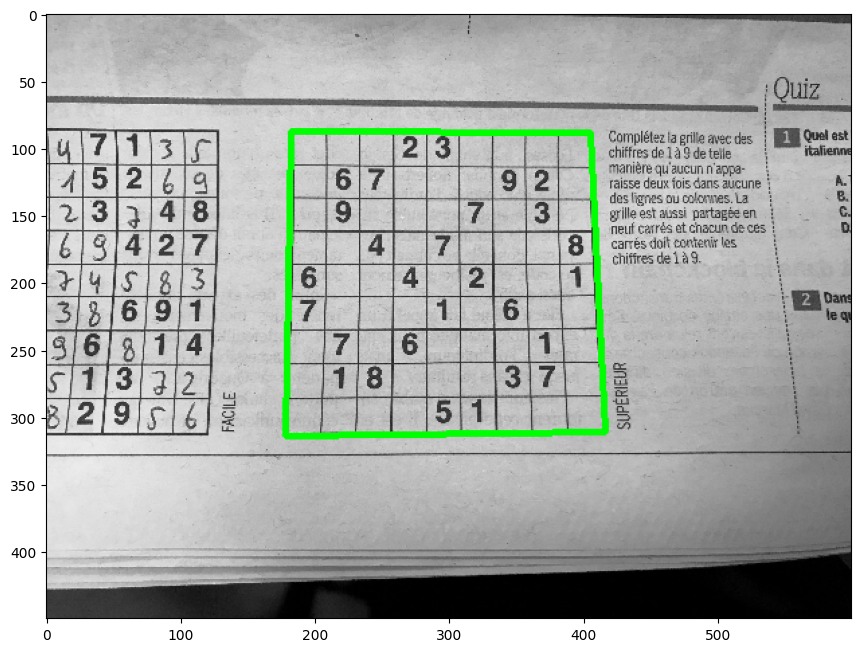

In [5]:
I_Contour=np.copy(Org)
I_Contour=cv.cvtColor(I_Contour,cv.COLOR_GRAY2RGB)
contours, hierarchy = cv.findContours(I,cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Find the index of the largest contour and aprox. it
areas = [cv.contourArea(c) for c in contours]
max_index = np.argmax(areas)
cnt=contours[max_index]
epsilon = 0.1*cv.arcLength(cnt,True)
approx = cv.approxPolyDP(cnt,epsilon,True)
cv.drawContours(I_Contour, [approx], -1, (0, 255, 0), 3)



plt.imshow(I_Contour)

[182  87 178 314 416 311 405  88]
[1223  584 1196 2110 2795 2089 2721  591]


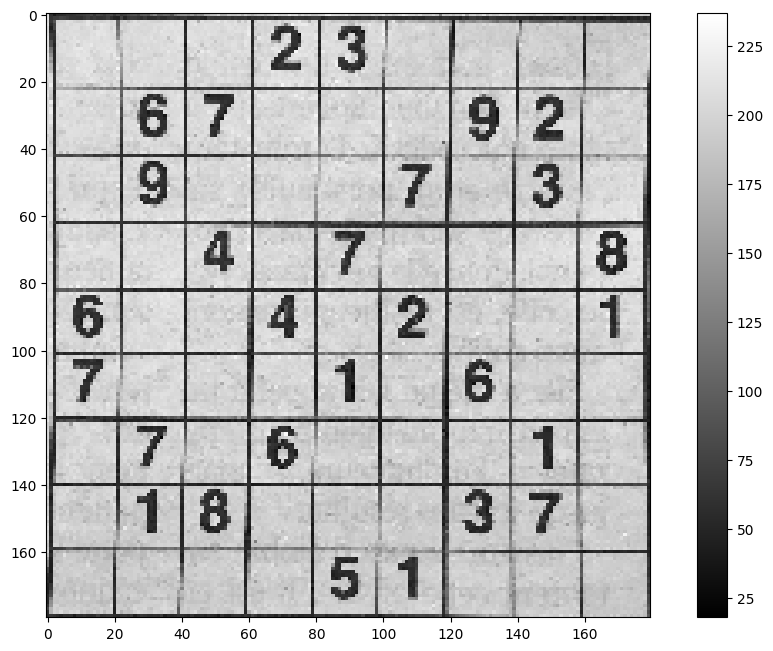

In [6]:
ROI=np.copy(Org_Color)
ROI=cv.cvtColor(ROI,cv.COLOR_RGB2GRAY)
h,w=ROI.shape
h_old,w_old=Org.shape
pts_src=approx.flatten()
print(pts_src)
for i in range(len(pts_src)):
    if i%2:
        pts_src[i]=pts_src[i]*h/h_old
    else:
        pts_src[i]=pts_src[i]*w/w_old
print(pts_src)
#pts_dst = np.float32([[15,15],[15,165],[165, 15],[165, 165]])
pts_dst = np.float32([[0,0],[0,180],[180, 0],[180, 180]])
pts_src=np.float32([[pts_src[0],pts_src[1]],[pts_src[2],pts_src[3]],[pts_src[6], pts_src[7]],[pts_src[4], pts_src[5]]])
trans = cv.getPerspectiveTransform(pts_src, pts_dst)
#ROI = cv.warpPerspective(ROI, trans, (180,180))
ROI = cv.warpPerspective(ROI, trans, (180,180))
plt.imshow(ROI)
plt.colorbar()

#### Fourth Step (Finding possible Digits)
* Inverting the image
* Creating an elongated ellipse kernel in the size of possible digits
* Using the kernel convolution to find possible positions
* Further imporvement of the result by non max supression and thresholding

33


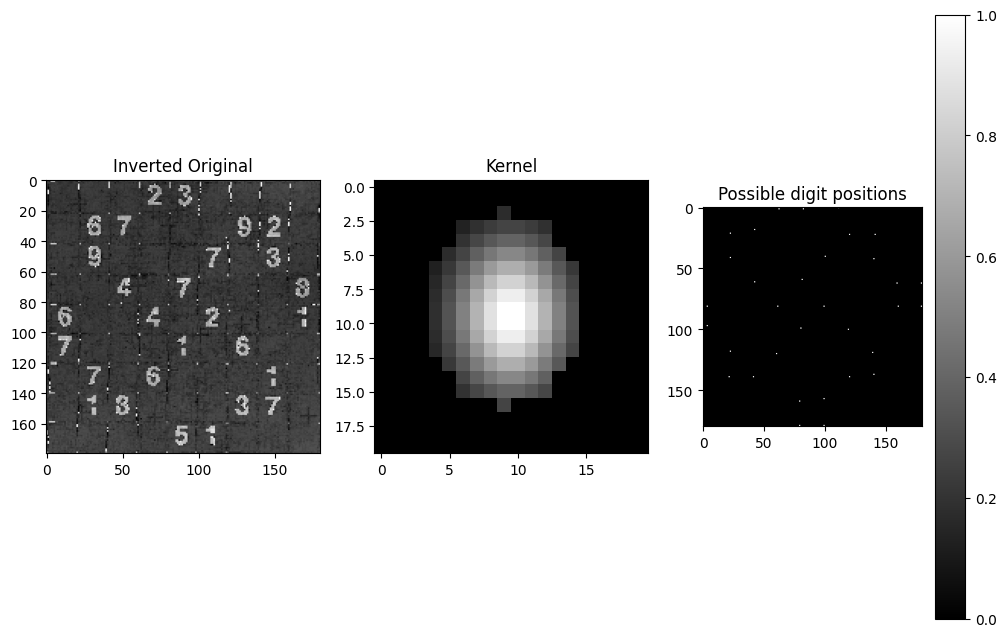

In [7]:
h,w=ROI.shape
possible_digits=[]
ROI=ROI-np.min(ROI)
digits=ROI\
        -cv.dilate(ROI,cv.getStructuringElement(cv.MORPH_RECT,(11,1)))\
        -cv.dilate(ROI,cv.getStructuringElement(cv.MORPH_RECT,(1,11)))

#kernel creation
kernel=np.zeros((20,20))
kernel[2:17,4:15]=cv.getStructuringElement(cv.MORPH_ELLIPSE,(11,15))
kernel*=np.dot(cv.getGaussianKernel(20,4),cv.getGaussianKernel(20,3).T)
kernel/=np.sum(kernel)

kernel2=np.dot(cv.getGaussianKernel(20,5),cv.getGaussianKernel(20,4).T)
kernel2[2:17,4:15]=0
kernel2/=np.sum(kernel2)
kernel2-=np.ones((20,20))
kernel2/=np.sum(abs(kernel2))
kernel=kernel+kernel2

#Convolution (anchor point=(0,0) --> shifted by (10,10)
img=cv.filter2D(digits,ddepth=cv.CV_32F,kernel=kernel,anchor=(0,0))

#Non max supression in a 20x20 region
max=cv.dilate(img,np.ones((20,20)))

#Thresholding
max=img==max
thr=img>15
max=thr*max

plt.subplot(131)
plt.imshow(digits)
plt.title("Inverted Original")
plt.subplot(132)
plt.title("Kernel")
plt.imshow(kernel)
plt.subplot(133)
plt.title("Possible digit positions")
plt.imshow(max)
plt.colorbar()
print(np.sum(max))

            

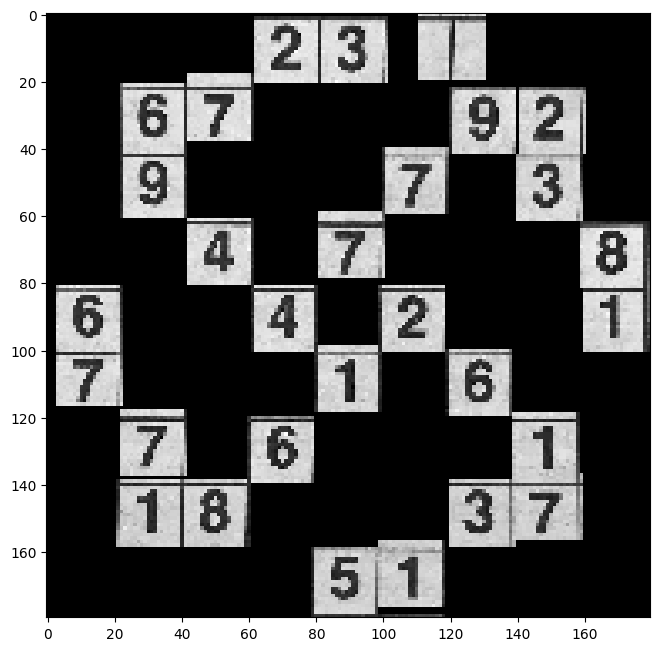

In [8]:
possible_digits=np.zeros(ROI.shape)
for i in range(h):
    for j in range(w):
        if max[i,j]:
            possible_digits[i:i+20,j:j+20]=ROI[i:i+20,j:j+20]
plt.imshow(possible_digits)
    